In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 2.5MB 7.5MB/s 
     |████████████████████████████████| 901kB 50.6MB/s 
     |████████████████████████████████| 3.3MB 49.0MB/s 


In [ ]:
!pip install contractions

     |████████████████████████████████| 327kB 8.8MB/s 
     |████████████████████████████████| 286kB 43.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85397 sha256=c87eef32b78e39d6099c9434790eb0f9b50cdcc73696b12708fc1beff2c1d036
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.8.2



In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import nltk
import contractions
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/SBU/NN/04/newtrain.csv',usecols=['lemmatize_text', 'target'])
df.head()

,target,lemmatize_text
0,1,deed reason earthquake may allah forgive u
1,1,forest fire near la ronge sask canada
2,1,resident ask shelter place notified officer ev...
3,1,13000 people receive wildfire evacuation order...
4,1,get send photo ruby alaska smoke wildfire pour...


In [ ]:
df.shape

(7613, 2)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'when was i last outside? i am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: when was i last outside? i am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1165, 1108, 178, 1314, 1796, 136, 178, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1165, 1108,  178, 1314, 1796,  136,  178, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'i',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []

for txt in df.lemmatize_text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


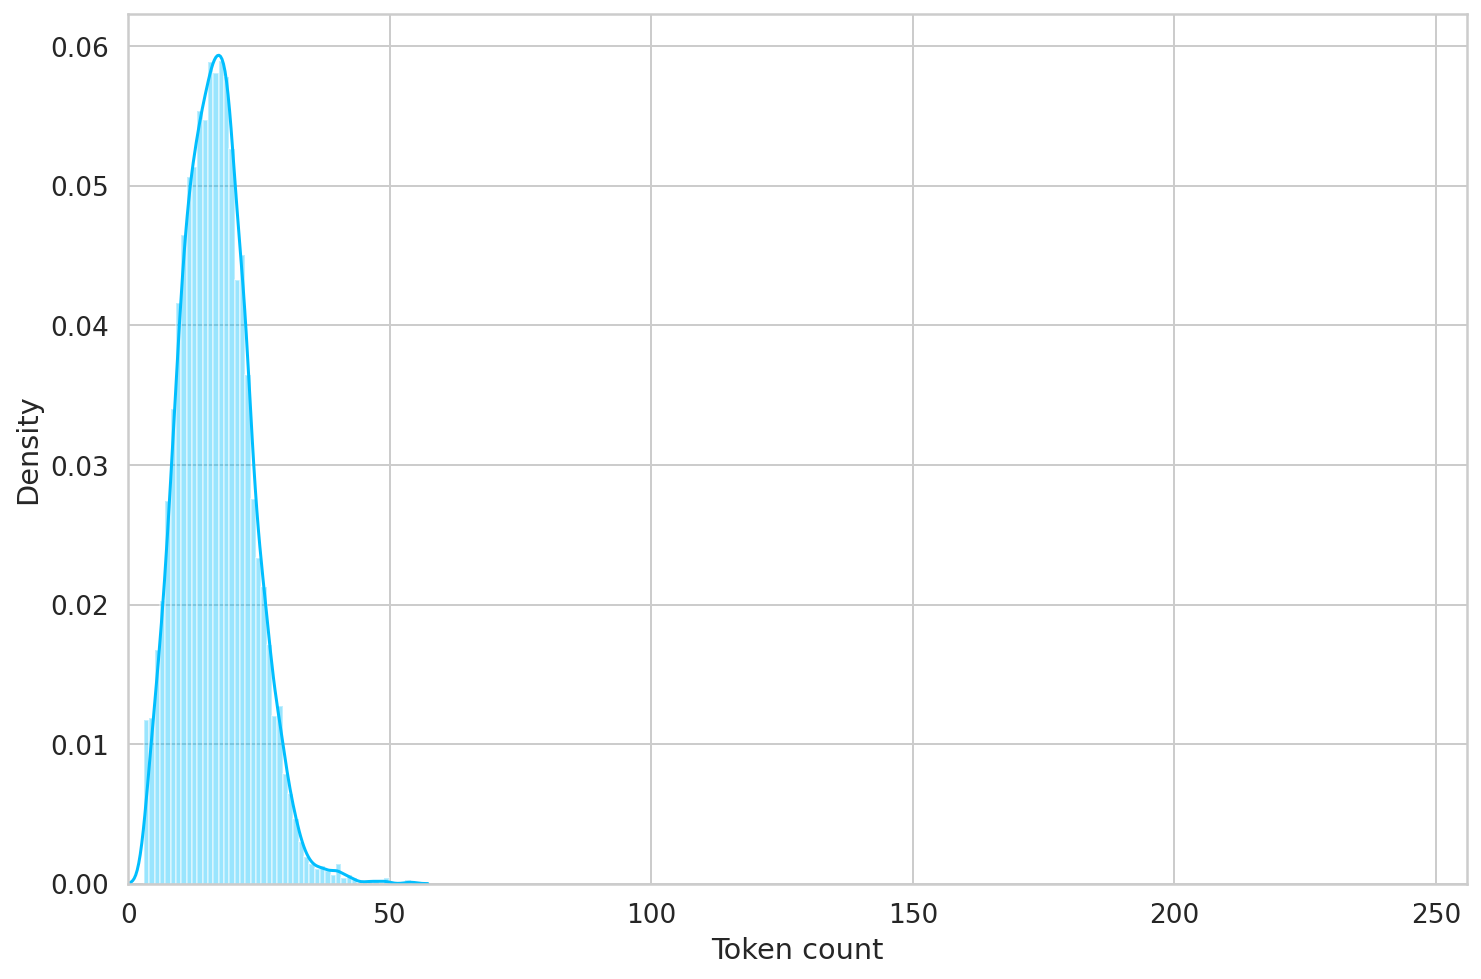

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 50

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((6851, 2), (381, 2), (381, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.lemmatize_text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[ 0.3707,  0.0924, -0.1264,  ..., -0.0093,  0.2924, -0.0730],
                                                        [ 0.1661, -0.7117,  0.4150,  ..., -0.1590,  0.2115,  0.1114],
                                                        [ 0.0145, -0.1927, -0.3987,  ...,  0.7138, -0.3750,  0.7183],
                                                        ...,
                                                        [ 0.1553,  0.1466, -0.2570,  ...,  0.0781,  0.0416,  0.2042],
                                                        [ 0.0157,  0.0476,  0.1196,  ...,  0.1977,  0.4048,  0.0452],
                                                        [-0.0166,  0.0887,  0.1806,  ...,  0.1156,  0.2524, -0.1337]]],
                                                      grad_fn=<NativeLayerNormBackward>)),
                                              ('pooler_output',
      

In [ ]:
bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[1]

tensor([[-7.3396e-01,  4.6406e-01,  9.9974e-01, -9.8088e-01,  9.5057e-01,
          8.1557e-01,  9.7658e-01, -9.5939e-01, -9.3094e-01, -6.0900e-01,
          9.4950e-01,  9.9553e-01, -9.9237e-01, -9.9959e-01,  4.6874e-01,
         -9.6001e-01,  9.7060e-01, -5.4067e-01, -9.9990e-01, -4.1026e-01,
         -2.8665e-02, -9.9972e-01,  3.0591e-01,  9.4520e-01,  9.4723e-01,
          5.7040e-02,  9.5950e-01,  9.9990e-01,  7.5801e-01,  2.1813e-01,
          2.8493e-01, -9.7820e-01,  7.7434e-01, -9.9670e-01,  2.1314e-01,
          7.9860e-02,  5.5276e-01, -2.7476e-01,  8.2523e-01, -8.8431e-01,
         -4.2983e-01, -4.6454e-01,  5.1065e-01, -5.4345e-01,  6.7987e-01,
          8.5051e-02,  3.6731e-01, -1.5189e-01, -3.3491e-01,  9.9990e-01,
         -9.2720e-01,  9.9944e-01, -9.7395e-01,  9.9181e-01,  9.8388e-01,
          2.8190e-01,  9.8292e-01,  2.0199e-01, -9.9345e-01,  2.5650e-01,
          9.0818e-01,  1.8655e-01,  8.4354e-01, -1.7613e-01, -2.0125e-01,
         -4.1845e-02, -8.5851e-01,  3.

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[1]
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = Classifier(2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 50])
torch.Size([16, 50])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2459, 0.7541],
        [0.3889, 0.6111],
        [0.3095, 0.6905],
        [0.2181, 0.7819],
        [0.1754, 0.8246],
        [0.2302, 0.7698],
        [0.2566, 0.7434],
        [0.2577, 0.7423],
        [0.2953, 0.7047],
        [0.2910, 0.7090],
        [0.1660, 0.8340],
        [0.3286, 0.6714],
        [0.1214, 0.8786],
        [0.1923, 0.8077],
        [0.3088, 0.6912],
        [0.3491, 0.6509]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.5938766289215821 accuracy 0.6984381842066851


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4945795064171155 accuracy 0.8031496062992126

Epoch 2/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.4787696854391576 accuracy 0.8089330024813896


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.47124187648296356 accuracy 0.8188976377952756

Epoch 3/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.43997661581823044 accuracy 0.8318493650561961


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4607703083505233 accuracy 0.8136482939632546

Epoch 4/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.3996295145341566 accuracy 0.850532768938841


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4445274497071902 accuracy 0.8267716535433071

Epoch 5/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.3760695031264445 accuracy 0.8668807473361553


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.44300408847630024 accuracy 0.8267716535433071

Epoch 6/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.34524648925745405 accuracy 0.8822069770836374


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.476793081810077 accuracy 0.8241469816272966

Epoch 7/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.3269322646265124 accuracy 0.8906728944679608


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4697656085093816 accuracy 0.8320209973753281

Epoch 8/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.30180517169874865 accuracy 0.9010363450591155


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4785016806175311 accuracy 0.8293963254593175

Epoch 9/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.28442083538829027 accuracy 0.9102320829076047


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5167773800591627 accuracy 0.8110236220472441

Epoch 10/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.27605250849017315 accuracy 0.9121296161144358


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.560570207114021 accuracy 0.8188976377952756

CPU times: user 12min 9s, sys: 23 s, total: 12min 32s
Wall time: 12min 41s


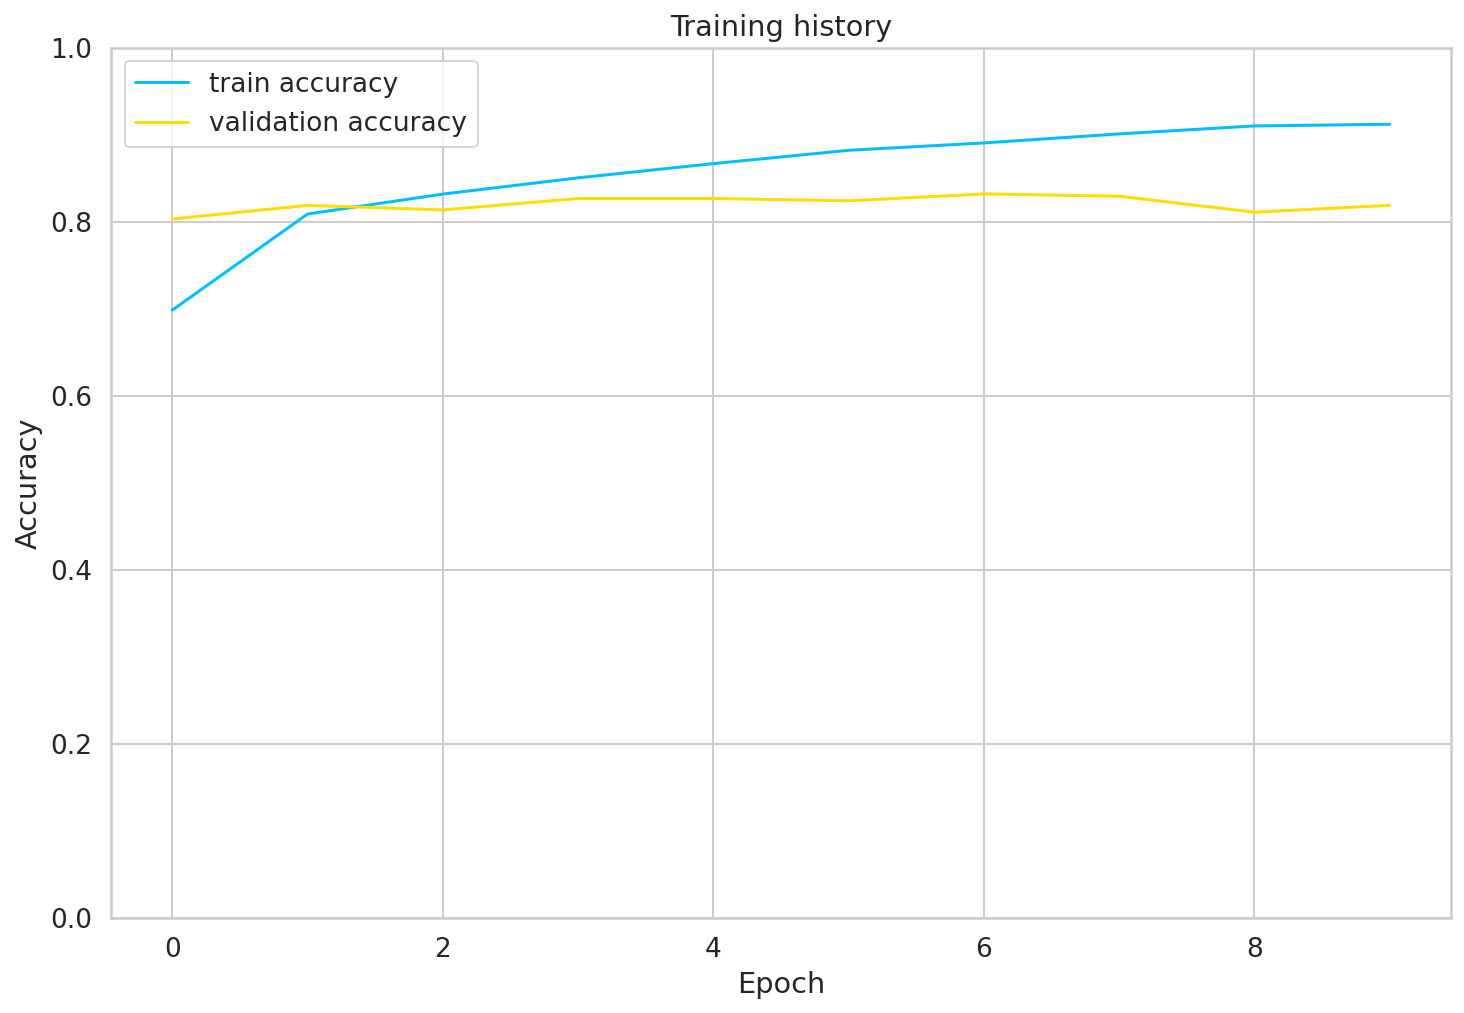

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.8136482939632546

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       209
           1       0.82      0.75      0.78       172

    accuracy                           0.81       381
   macro avg       0.81      0.81      0.81       381
weighted avg       0.81      0.81      0.81       381



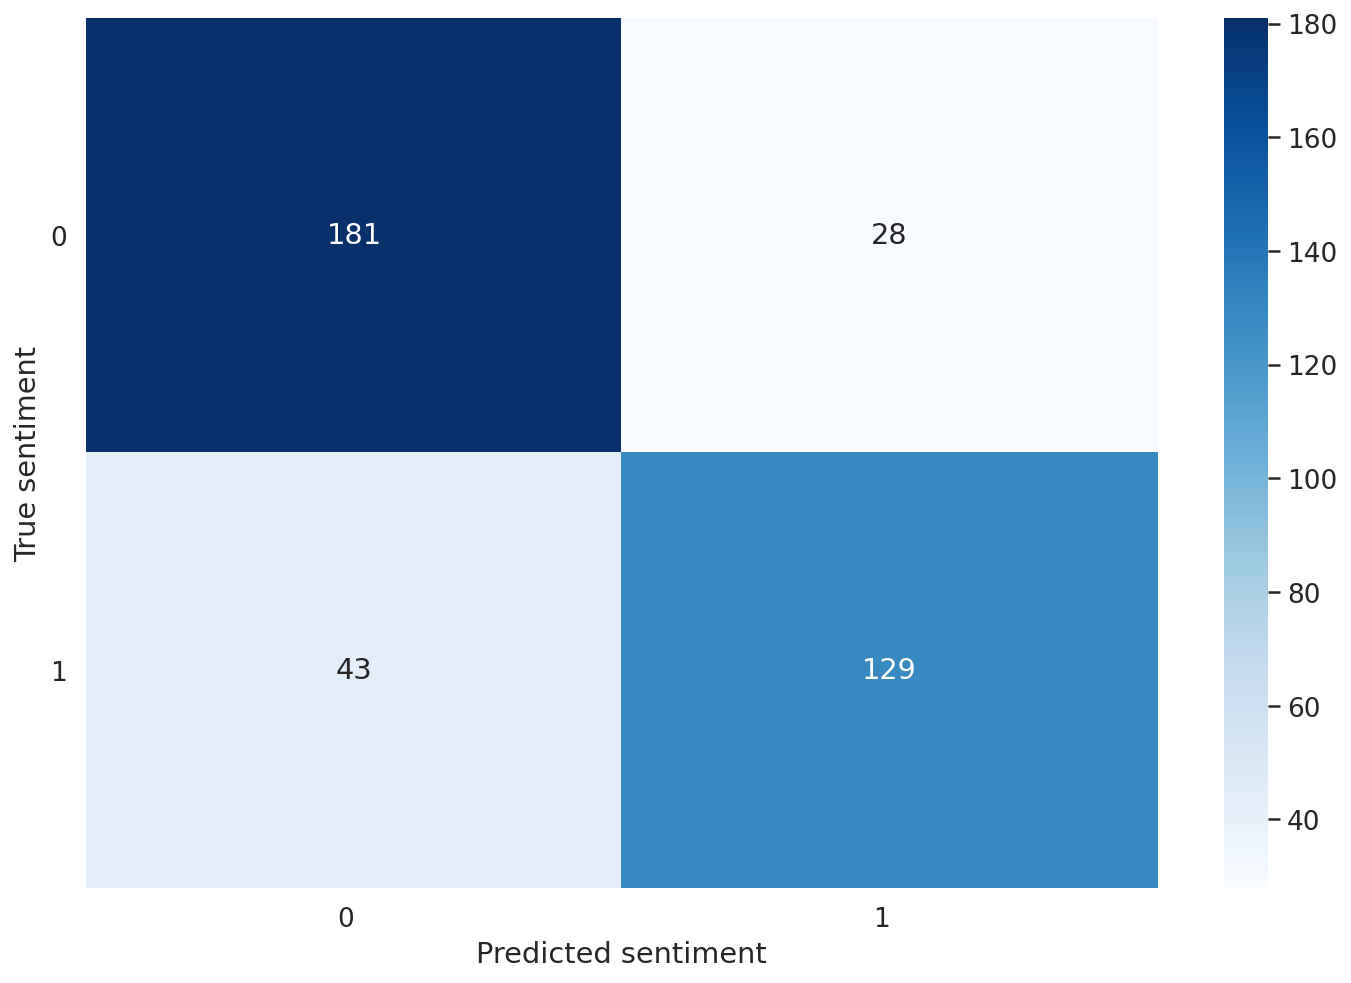

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['0','1'], columns=['0','1'])
show_confusion_matrix(df_cm)